<a href="https://colab.research.google.com/github/Artin-Tavasoli/Neural-Network/blob/main/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

# 🧠 Convolutional vs. Fully Connected Neural Networks

###  **Artin Tavasoli** 👋🏻
📘 **Student ID:** `810102543`

</div>


# Overview
In this assignment, we will compare fully connected neural networks with convolutional neural networks to evaluate whether convolutional architectures offer superior performance—and understand the reasons behind any observed differences.


## Device

As demonstrated in the PyTorch tutorial, PyTorch enable you to run your code on GPU to accelerate computations.

In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

<span style="font-size:30px; font-weight:bold; color:pink;">📚 Import Needed Libraries</span>


In [2]:
import torch
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn as nn
import math
import torch.optim as optim
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors



# Dataset

## Transforms & Dataset & Dataloader

transforms.Compose: applies a sequence of transformations within in it in a sequential order to the input image.

transforms.ToTensor:  converts the images from a PIL Image format to a PyTorch tensor

transforms.Normalize: normalizes each pixel's values, mean and standard deviation of the CIFAR-10 dataset for each color channel (Red, Green, Blue) are given as a tuple.

Why Normalize?

 - Gradient descent algorithms might oscillate or take longer to find the optimal solution. Normalizing the data helps ensure that all features are on a similar scale, which can lead to faster convergence during training.

- Neural networks are sensitive to the scale of input features. If the features have widely varying ranges, the weights in the network will need to adjust to accommodate these differences.

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])

To shuffle or not?

- Shuffling the training data in each epoch helps the model see different combinations of data in each batch which helps in avoiding learning patterns based on the order of samples.

- Evaluation is Order-Independent,  When calculating metrics like loss and accuracy on the validation and test sets, the order in which the samples are processed does not matter.

In [5]:
batch_size = 512

initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainset, valset = random_split(initial_trainset, [45000, 5000])

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:14<00:00, 12.0MB/s]


What are Dataloaders?
- They are iterables that provide batches of data

- according to code below:

    each batch contains 512 images and each image has 32 * 32 pixels and 3 RGB values
    
    total dimension for each batch = 32,32,3

In [6]:
for batch_idx, (images, labels) in enumerate(trainloader):
    print('images shape is: ',images.shape)
    print('labels shape is: ',labels.shape)
    for image in images:
      print('image shape is: ', image.shape)
      print('an image in tensor format: \n',image)
      break
    break

images shape is:  torch.Size([512, 3, 32, 32])
labels shape is:  torch.Size([512])
image shape is:  torch.Size([3, 32, 32])
an image in tensor format: 
 tensor([[[ 0.4889,  0.4730,  0.5048,  ..., -0.0191, -0.1779, -0.1938],
         [ 0.5842,  0.5683,  0.5683,  ..., -0.0033, -0.0826, -0.0985],
         [ 0.5366,  0.4889,  0.4413,  ..., -0.0191, -0.0033, -0.0350],
         ...,
         [ 1.3780,  1.0446,  0.9970,  ...,  0.5048,  0.4572,  0.1079],
         [ 1.2351,  0.8700,  0.7430,  ...,  1.0922,  0.7112,  0.0126],
         [ 1.1716,  0.9176,  0.5683,  ...,  1.0764,  1.1081,  0.6159]],

        [[ 0.6147,  0.6308,  0.6954,  ...,  0.2274,  0.1144,  0.1306],
         [ 0.7438,  0.7761,  0.8084,  ...,  0.2274,  0.1467,  0.1628],
         [ 0.7438,  0.7277,  0.7277,  ...,  0.2274,  0.2274,  0.1951],
         ...,
         [ 1.2764,  0.9213,  1.0020,  ...,  0.5986,  0.5824,  0.4049],
         [ 1.1634,  0.7922,  0.7438,  ...,  1.0504,  0.7277,  0.2597],
         [ 1.1150,  0.8568,  0.5663,

## Visualization

inverse the normilize transform to restore the original data

std and mean shape is (3), we need to broadcast this to (3,1,1). now when we add this with a (3,32,32) tensor, for a single color, means we want to add a 1 by 1 with a 32 by 32, here it copies the 1by1 into a 32by32 and then does the sumation


In [7]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def __call__(self, tensor, gray=False, coeff=(0.3, 0.59, 0.11)):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be unnormalized.
        Returns:
            Tensor: Unnormalized image.
        """
        image_tensor = tensor.clone()
        if not gray:
            image_tensor *= self.std.view(3, 1, 1)
            image_tensor += self.mean.view(3, 1, 1)
        else:
            image_tensor *= self.std
            image_tensor += self.mean
        return image_tensor

norminv = UnNormalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261))

HOW To VISUALIZE?

1. collect normalized images

2. convert them to unnormalized

3. change order of dimensions:
  our UnNormalize class returns a (C, H, W) tensor image but for visualization we need (H,W,C). permute in PyTorch is used for this purpose.

4. give it to Matplotlib's imshow() function:
  but before that note that this function expects pixel values to be within a valid range for the data type  0-1 for float data and accepts them as a numpy array. np.clip is used for this purpose.

Collected 5 images for all classes. Stopping iteration.


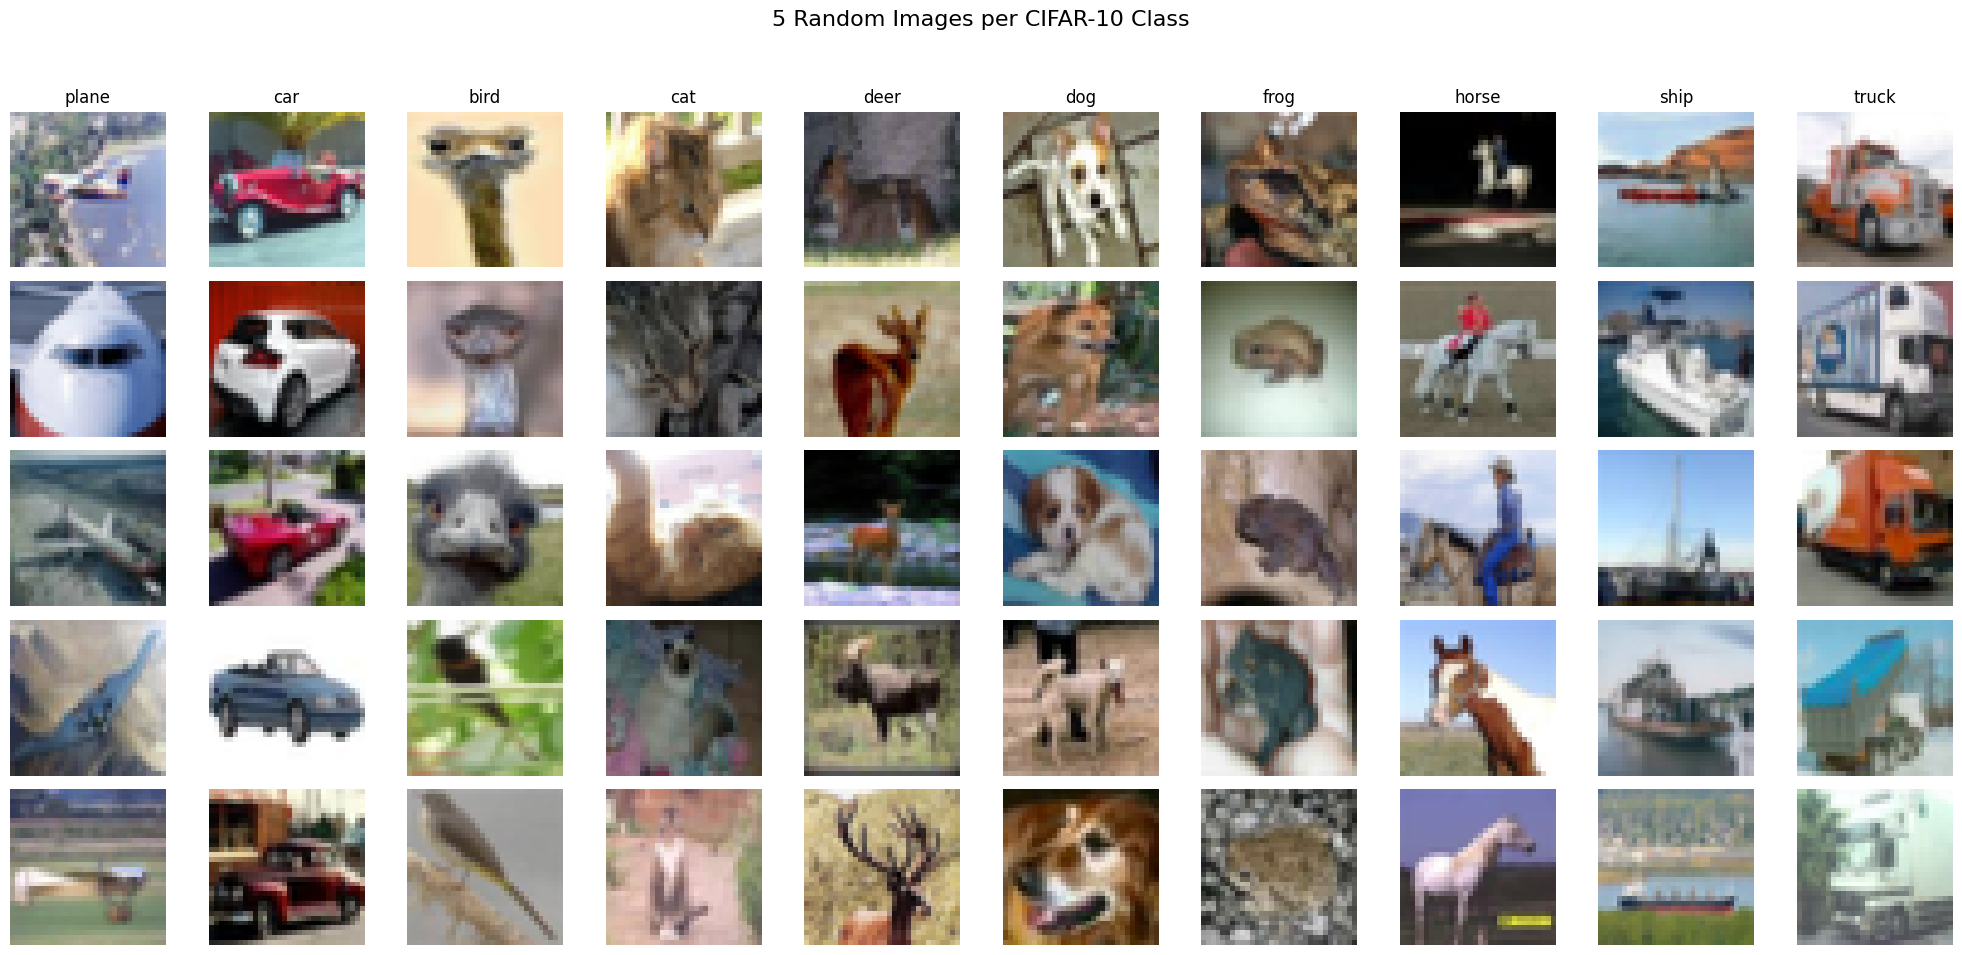

In [8]:
images_class = {}
for cls in classes:
    images_class[cls] = []

finished_collecting_images = False

for batch_idx, (images, labels) in enumerate(trainloader):
    if finished_collecting_images:
        break
    for i in range(images.size(0)):
        all_classes_full = all(len(img_list) == 5 for img_list in images_class.values())
        if all_classes_full:
            print("Collected 5 images for all classes. Stopping iteration.")
            finished_collecting_images = True
            break
        image = images[i]
        label = labels[i]
        class_name = classes[label]
        if len(images_class[class_name]) < 5:
          images_class[class_name].append(image.clone())


fig, axes = plt.subplots(5, len(classes), figsize=(20, 10))
fig.suptitle('5 Random Images per CIFAR-10 Class', fontsize=16)

for col, class_name in enumerate(classes):
    axes[0, col].set_title(class_name)
    current_class_images = images_class[class_name]
    for row in range(5):
        image = current_class_images[row]
        unnormalized_image = norminv(image)
        img_array = unnormalized_image.permute(1, 2, 0).numpy()
        img_array = np.clip(img_array, 0, 1)
        axes[row, col].imshow(img_array)
        axes[row, col].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Fully Connected Neural Netwrok

To ensure a fair comparison with convolutional neural networks (CNNs), both models should have approximately the same number of trainable parameters. Specifically, the fully connected model should contain **33,500,000 ± 500,000** trainable parameters.

## Model Construction:

- FullyConnectedNetwork : This class is a child of nn.module class, with our desired tailored needs.

- nn.Module: creating new modules by combining and extending the functionality provided by existing PyTorch modules. Includes some key features that are important for building neural networks, such as the ability to keep track of learnable parameters and the ability to perform automatic differentiation.

- super(FullyConnectedNetwork, self).__init__(): invokes the __init__ method to it's parent class, in other words calling nn.module's constructor.

- nn.Flatten: change tensor shape, with n being batch size:
  
  Input shape: (N, 3, 32, 32) --> output shape: (N, 3 * 32 * 32)

- nn.Linear: applies a linear transformation on the input using its stored weights and biases. y = Wx + b

- nn.ReLU: Non-linear activations will create complex mappings between the model's inputs and outputs.

- nn.Dropout: During training, in each forward pass, randomly zeroes some of the elements of the input tensor with probability p. Great for avoiding overfitting because the model learns Regularization, meaning no single neuron will carry the entire burden of representing a feature. Introduces more robustness.

- Logits: Is the raw output of the network, before any softmax or probability normalization


In [9]:
class FullyConnectedNetwork(nn.Module):
    def __init__(self, input_shape=(3, 32, 32), num_classes=10,
                 hidden_size=4400, drop_probability=0.5):
        super(FullyConnectedNetwork, self).__init__()

        self.flatten = nn.Flatten()

        self.hidden_linear_relu_stack = nn.Sequential(
            nn.Linear(input_shape[0] * input_shape[1] * input_shape[2], hidden_size),
            nn.ReLU(),
            nn.Dropout(p=drop_probability),

            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=drop_probability)
        )

        self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden_linear_relu_stack(x)
        logits = self.linear(x)
        return logits


## Trainable params

Based on the defined architecture above, manually calculated the total number of trainable parameters:

for hidden_size  = 4400:

Hidden layer 1:

- Input features: 3 * 32 * 32 = 3072

- Output features: 4400

- Number of params: 4400 * 3072 (weights) + 4400 (biases) =  13,521,200 params

Hidden layer 2:

- Input features: 4400

- Output features: 4400

- Number of params: 4400 * 4400 (weights) + 4400 (biases) =  19,364,400 params

Final layer:

- Input features: 4400

- Output features: 10

- Number of params: 4096 * 10 (weights) + 10 (biases) =  44,010 params

Total params: 32,929,610


Once you have completed your hand calculation, you can verify your result by running the following cell:

In [10]:
from torchsummary import summary
summary(FullyConnectedNetwork().to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                 [-1, 4400]      13,521,200
              ReLU-3                 [-1, 4400]               0
           Dropout-4                 [-1, 4400]               0
            Linear-5                 [-1, 4400]      19,364,400
              ReLU-6                 [-1, 4400]               0
           Dropout-7                 [-1, 4400]               0
            Linear-8                   [-1, 10]          44,010
Total params: 32,929,610
Trainable params: 32,929,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.22
Params size (MB): 125.62
Estimated Total Size (MB): 125.85
----------------------------------------------------------------


## Train

### Model Instantiation

Create an instance of your model and move it to your selected device (CPU or GPU). Refer to the PyTorch-tutorial notebook for guidance on how to perform this operation.

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FullyConnectedNetwork().to(device)
print(model)

FullyConnectedNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden_linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=4400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4400, out_features=4400, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (linear): Linear(in_features=4400, out_features=10, bias=True)
)


### Criterion & Optimizer


#### Criterion:
 To train a neural network, we require a **loss function** (referred to as the *criterion*) to quantify the difference between the model's predictions and the true labels. This loss is then used to compute the gradients of the model parameters.

- NLLLoss: Negative log likelihood loss. Log-likelihood, Maximizes the predicted probabilities assigned to the correct labels (True Positive and True Negative). Minimizing the Negative Log-Likelihood means minimizing loss

$$
l(\theta) = -\sum_{i=1}^{n} \left( y_i \log \hat{y}_{\theta,i} + (1 - y_i) \log (1 - \hat{y}_{\theta,i}) \right)
$$

- Softmax: a function that turns raw scores into probabilities. It takes a list of numbers (logits) and squashes them so they add up to 1


- CrossEntropyLoss: applying LogSoftmax on an input, followed by NLLLoss

In addition, an **optimization algorithm** is needed to update the model's parameters using the calculated gradients, in order to minimize the loss over time.

#### Optimizer:
  Problems with w ← w - η∇L(w)

  1. a fixed global 𝜂 can be suboptimal (different parameters may need different learning rates)

  2. Noisy gradients, due to mini-batch sampling can cause zig-zag updation, momentum helps in smoothing this.

  - Momentum:  keeps a running average of past gradients
  - RMSProp: keeps a running average of squared gradients
  - Adam = Adaptive moment estimation.  combination of momentum-like smoothing and RMS-like scaling

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

# Training the model
net.train: sets the module to training mode, crucial because we used dropout that is only on in training.

for each batch, update model with single epoch:

- optimizer.zero_grad: In PyTorch by default gradients are accumulated, we clear the gradients  before computing.

- Forward Pass: By simply giving images tensors to model, automatically __call__ function computes the perdicted labels, we can then  calculate loss using this and the actual labels and our criterion function.

- Backward Pass:

  loss.backward: Computes the gradients of the loss

  optimizer.step: Updates the network's parameters using the  gradients and optimizer.

# Evaluating the model

pretty much the like training but use
- net.eval
- with torch.no_grad: disables gradient calculation

In [13]:
def calculate_loss_and_accuracy(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer = None):
    number_of_losses = 0.0
    number_of_correct_predictions = 0
    number_of_samples_seen = 0

    device = next(net.parameters()).device

    for batch_idx, (images, labels) in enumerate(dataloader):
        size_of_batch = images.size(0)

        images, labels = images.to(device), labels.to(device)


        if optimizer:
            optimizer.zero_grad()

        predicted_labels = net(images)
        loss = criterion(predicted_labels, labels)

        if optimizer:
            loss.backward()
            optimizer.step()

        number_of_losses += (loss.item() * size_of_batch)

        _, predicted = torch.max(predicted_labels.data, 1)
        number_of_samples_seen += labels.size(0)
        number_of_correct_predictions += (predicted == labels).sum().item()

    avg_loss = number_of_losses / number_of_samples_seen
    accuracy = 100 * number_of_correct_predictions / number_of_samples_seen
    return avg_loss, accuracy

def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer ,dataloader: torch.utils.data.DataLoader):
    net.train()
    return calculate_loss_and_accuracy(net, criterion, dataloader, optimizer)

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    net.eval()
    with torch.no_grad():
        return calculate_loss_and_accuracy(net, criterion, dataloader)

As previously mentioned, ensuring a fair comparison between models requires consistency in certain aspects of the training setup. One key factor is the number of **trainable parameters**, and another is the number of times the model processes the entire dataset—referred to as an **epoch**.

To maintain consistency in training duration across models, **do not modify** the `epochs` variable defined below.


In [14]:
epochs = 50

history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}


for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
    val_loss, val_acc = eval_epoch(model, criterion, valloader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"(Epoch {epoch + 1} / {epochs}) train loss:{train_loss: .4f}; train acc:{train_acc: .2f}%; val loss:{val_loss: .4f}; val_acc:{val_acc: .2f}%")

(Epoch 1 / 50) train loss: 1.7574; train acc: 37.63%; val loss: 1.5757; val_acc: 45.14%
(Epoch 2 / 50) train loss: 1.5522; train acc: 45.30%; val loss: 1.4882; val_acc: 48.08%
(Epoch 3 / 50) train loss: 1.4670; train acc: 48.45%; val loss: 1.4620; val_acc: 48.92%
(Epoch 4 / 50) train loss: 1.3971; train acc: 51.31%; val loss: 1.4237; val_acc: 51.12%
(Epoch 5 / 50) train loss: 1.3447; train acc: 53.14%; val loss: 1.4021; val_acc: 51.38%
(Epoch 6 / 50) train loss: 1.3035; train acc: 54.32%; val loss: 1.3702; val_acc: 52.78%
(Epoch 7 / 50) train loss: 1.2638; train acc: 56.03%; val loss: 1.3867; val_acc: 52.50%
(Epoch 8 / 50) train loss: 1.2229; train acc: 57.46%; val loss: 1.3549; val_acc: 53.04%
(Epoch 9 / 50) train loss: 1.1789; train acc: 58.68%; val loss: 1.3311; val_acc: 54.14%
(Epoch 10 / 50) train loss: 1.1494; train acc: 60.09%; val loss: 1.3286; val_acc: 54.16%
(Epoch 11 / 50) train loss: 1.1100; train acc: 61.18%; val loss: 1.3230; val_acc: 53.98%
(Epoch 12 / 50) train loss: 1.

### Save Model

Save the trained model for use in subsequent sections to avoid retraining it later.


In [15]:
torch.save(model.state_dict(), "fully-connected.pth")

In [16]:
# To load the previously saved model, simply uncomment the code below.
# model.load_state_dict(torch.load('fully-connected.pth'))

### Visualize Loss and Accuracy plot

At about 15 epochs the model begins to overfit, meaning it's beginning to fail at generalizing, that's why training loss decreases but validation loss starts rising up and the accuracy fluctuates ( the model can not further find a pattern and due to the stochastic nature of the model like mini-batch and dropout we see fluctuations )

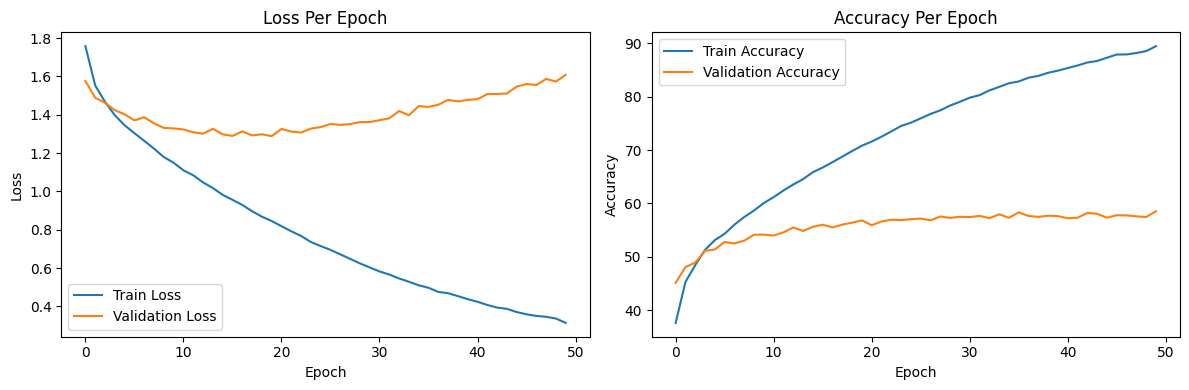

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `60%`

In [18]:
test_loss, test_accuracy = eval_epoch(model, criterion, testloader, test_mode=True)

print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Loss:     1.5648
Test Accuracy: 58.60%


# Convolutional Neural Network

## Model


![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

### CNN Architecture:

  Input Layer: a 3x32x32 image

  Blocks consist of:

  - Convolutional Layers (nn.Conv2d):
   
   They apply a set of learnable filters (kernels) to the input image. Each filter slides over the input, performing a convolution operation

  nn.Conv2d(in_channels=3, out_channels=64,...)

  initially in_channels is 3 (RGB) and this layer has 64 distinct filters, each one slides over the input, performing a convolution operation, therefore 64 outputs.

  3x32x32 -> 64x32x32

  - Activation (nn.ReLU) and Batch Normalization (nn.BatchNorm2d) and DropOut

  - Pooling Layers (nn.MaxPool2d):
  
   These layers reduce the spatial dimensions (width and height) of the feature maps. Max pooling, maximumizes value within a defined window, downsampling the feature maps.

   nn.MaxPool2d(kernel_size=2, stride=2): 64x32x32 -> 64x16x16

After several Blocks,

  - convert 3D vector to 1D with flatten

  - Fully Connected Layers (nn.Linear):

    they take the flattened features from the convolutional layers and use them to perform the final classification
    and produce raw scores

  - Softmax: covert raw scores to probabilities.


In [19]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        self.flatten = nn.Flatten()

        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 64x16x16
            nn.Dropout(p=0.25),

            # Block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 128x8x8
            nn.Dropout(p=0.25),

            # Block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 256x4x4
            nn.Dropout(p=0.25),
        )

        self.conv_output_size = 256 * 4 * 4

        N = 7750

        self.feature_space_layer = nn.Linear(self.conv_output_size, N)

        self.last_relu = nn.ReLU()

        self.last_dropout = nn.Dropout(p=0.5)

        self.linear = nn.Linear(N, num_classes)


    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.feature_space_layer(x)
        x = self.last_relu(x)
        x = self.last_dropout(x)
        logits = self.linear(x)
        return logits

## Trainable params

Based on the defined architecture, manually calculate the total number of trainable parameters:

Formulas for number of params:

- nn.Conv2d:

  in_channels * kernel_height * kernel_width * out_channels
  (for weights) + out_channels (for biases)

- nn.BatchNorm2d:

 the trainable parameters are the scaling factor (gamma) and the shifting factor (beta) for each feature map.
  2 * out_channels

- Block 1:
  
  Conv2d: 3x3x3x64 + 64 = 1,792

  BatchNorm2d: 2x64 = 128
  
  Conv2d: 3x3x64x64 + 64 = 36,928
  
  BatchNorm2d: 2x64 = 128

- Block 2:

  Conv2d: 3x3x64x128 + 128 = 73,856

  BatchNorm2d: 2x128 = 256
  
  Conv2d: 3x3x128x128 + 128 = 147,584
  
  BatchNorm2d: 2x128 = 256

- Block 3:

  Conv2d: 3x3x128x256 + 256 = 295,168

  BatchNorm2d: 2x256 = 512
  
  Conv2d: 3x3x256x256 + 256 = 590,080
  
  BatchNorm2d: 2x256 = 512

- Fully Connected:
  
  Linear(feature space layer):  
  
  input = 256x4x4 = 4096

  output = 7750
  
  4096x7750+7750 = 31,751,750

  Linear(output):

  7750x10+10 = 77,510

Total Parameters = 32,976,460

Verify the result by running the following cell:

In [20]:
from torchsummary import summary
summary(CNN().to(device), input_size=(3, 32, 32));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4           [-1, 64, 32, 32]          36,928
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
         MaxPool2d-7           [-1, 64, 16, 16]               0
           Dropout-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
             ReLU-10          [-1, 128, 16, 16]               0
      BatchNorm2d-11          [-1, 128, 16, 16]             256
           Conv2d-12          [-1, 128, 16, 16]         147,584
             ReLU-13          [-1, 128, 16, 16]               0
      BatchNorm2d-14          [-1, 128,

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=10).to(device)

### Criterion & Optimizer

Define `criterion` and `optimizer`

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

In [23]:
epochs = 50
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
    val_loss, val_acc = eval_epoch(model, criterion, valloader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"(Epoch {epoch + 1} / {epochs}) train loss:{train_loss: .4f}; train acc:{train_acc: .2f}%; val loss:{val_loss: .4f}; val_acc:{val_acc: .2f}%")

(Epoch 1 / 50) train loss: 1.5779; train acc: 43.62%; val loss: 1.5345; val_acc: 47.88%
(Epoch 2 / 50) train loss: 1.1608; train acc: 58.48%; val loss: 1.3394; val_acc: 54.10%
(Epoch 3 / 50) train loss: 0.9849; train acc: 64.92%; val loss: 1.1201; val_acc: 61.98%
(Epoch 4 / 50) train loss: 0.8595; train acc: 69.47%; val loss: 1.0079; val_acc: 64.68%
(Epoch 5 / 50) train loss: 0.7560; train acc: 73.40%; val loss: 0.9583; val_acc: 67.28%
(Epoch 6 / 50) train loss: 0.6846; train acc: 75.77%; val loss: 0.8532; val_acc: 70.50%
(Epoch 7 / 50) train loss: 0.6208; train acc: 78.11%; val loss: 0.8167; val_acc: 72.10%
(Epoch 8 / 50) train loss: 0.5668; train acc: 80.24%; val loss: 0.7776; val_acc: 73.74%
(Epoch 9 / 50) train loss: 0.5187; train acc: 81.83%; val loss: 0.7119; val_acc: 75.76%
(Epoch 10 / 50) train loss: 0.4733; train acc: 83.35%; val loss: 0.6988; val_acc: 76.14%
(Epoch 11 / 50) train loss: 0.4277; train acc: 85.03%; val loss: 0.6826; val_acc: 77.48%
(Epoch 12 / 50) train loss: 0.

### Save Model

Since changes need to be made to the model later on, it is advisable to save your model to avoid having to retrain it in case of any issues.

In [24]:
torch.save(model.state_dict(), "cnn.pth")

In [25]:
# To load the previously saved model, simply uncomment the code below.
# model.load_state_dict(torch.load('cnn.pth'))

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

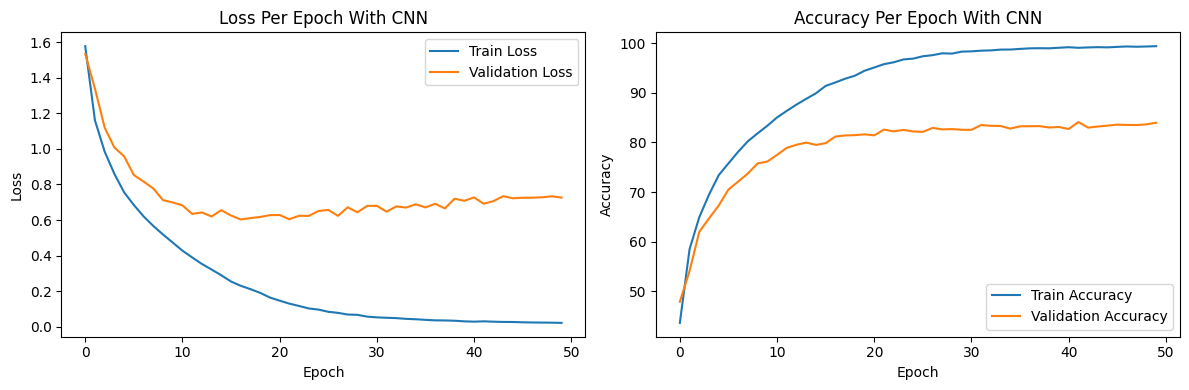

In [26]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Per Epoch With CNN')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Per Epoch With CNN')
plt.legend()

plt.tight_layout()
plt.show()


## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [27]:
test_loss, test_accuracy = eval_epoch(model, criterion, testloader, test_mode=True)

print(f"Test Loss with CNN:     {test_loss:.4f}")
print(f"Test Accuracy with CNN: {test_accuracy:.2f}%")

Test Loss with CNN:     0.7222
Test Accuracy with CNN: 84.01%


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model. Note that if you used normalization in the transform function for loading the data, you will need to unnormalize the images before displaying them.

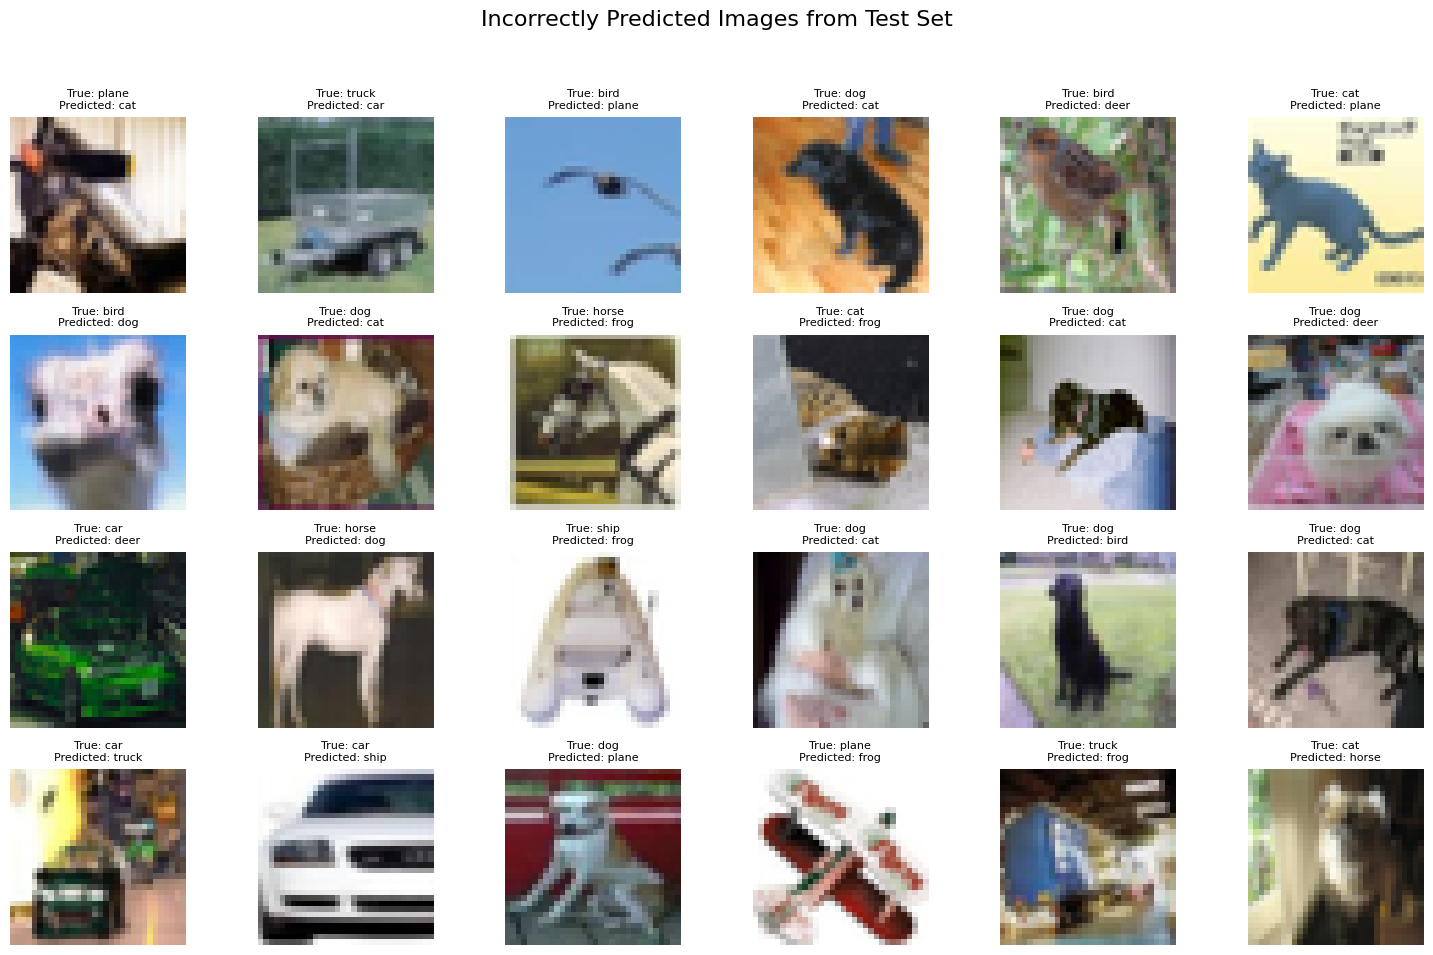

In [28]:
model.eval()
misclassified_images = []
device = next(model.parameters()).device
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(testloader):
        for i in range(images.size(0)):
            image = images[i].to(device)
            label = labels[i]
            image_tensor = image.unsqueeze(0)
            predicted_labels = model(image_tensor)
            _, predicted = torch.max(predicted_labels.data, 1)

            if predicted.item() != label:
                misclassified_images.append((images[i], predicted.item(), label.item()))


random_misclassified_images = random.sample(misclassified_images, 24)

fig, axes = plt.subplots(4, 6, figsize=(15, 10))
fig.suptitle('Incorrectly Predicted Images from Test Set', fontsize=16)

for i, (image, predicted_label, true_label) in enumerate(random_misclassified_images):
    unnormalized_image = norminv(image)
    img_array = unnormalized_image.permute(1, 2, 0).numpy()
    img_array = np.clip(img_array, 0, 1)

    ax = axes[i // 6, i % 6]
    ax.imshow(img_array)
    ax.set_title(f'True: {classes[true_label]}\nPredicted: {classes[predicted_label]}', fontsize=8)
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Exploring the feature space

### Calculate the feature space for all training samples

For each sample in the trainset, calculate it's "feature space" discussed in the model section.
- feature space is the output of a specific layer (or sequence of layers) before the final classification layer.


In [29]:
trainloader = DataLoader(trainloader.dataset, batch_size=trainloader.batch_size, shuffle=False)
model.eval()
feature_space_list = []
device = next(model.parameters()).device

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(trainloader):
        images = images.to(device)

        conv_output = model.conv_layers(images)
        flattened_output = model.flatten(conv_output)
        feature_output = model.feature_space_layer(flattened_output)

        feature_space_list.append(feature_output.cpu())

feature_space = torch.cat(feature_space_list, dim=0)

print(f"Calculated feature space of size: {feature_space.shape}")

Calculated feature space of size: torch.Size([45000, 7750])


### K Nearest Neighbor in feature space

Overview
1. Selects Correctly Predicted Test Samples:

 It starts by finding 5 random test images that the CNN model has correctly classified (can assume that for these samples, the CNN has learned a reasonably good feature representation).
2. Calculates Feature Space for Test Samples:

 For each of these selected test images, it passes them through the CNN up to the feature space layer to get their feature vector representation

3. Finds Nearest Neighbors in Training Feature Space:

 finds the 5 nearest neighbors to the test sample's feature vector within the entire collection of training feature vectors.

4. Visualizes and Analyzes Neighbors:

  You can see what kinds of images are considered "close" to our test image in the network's learned feature space.

KNN is used as a tool to probe the structure of the feature space learned by our CNN

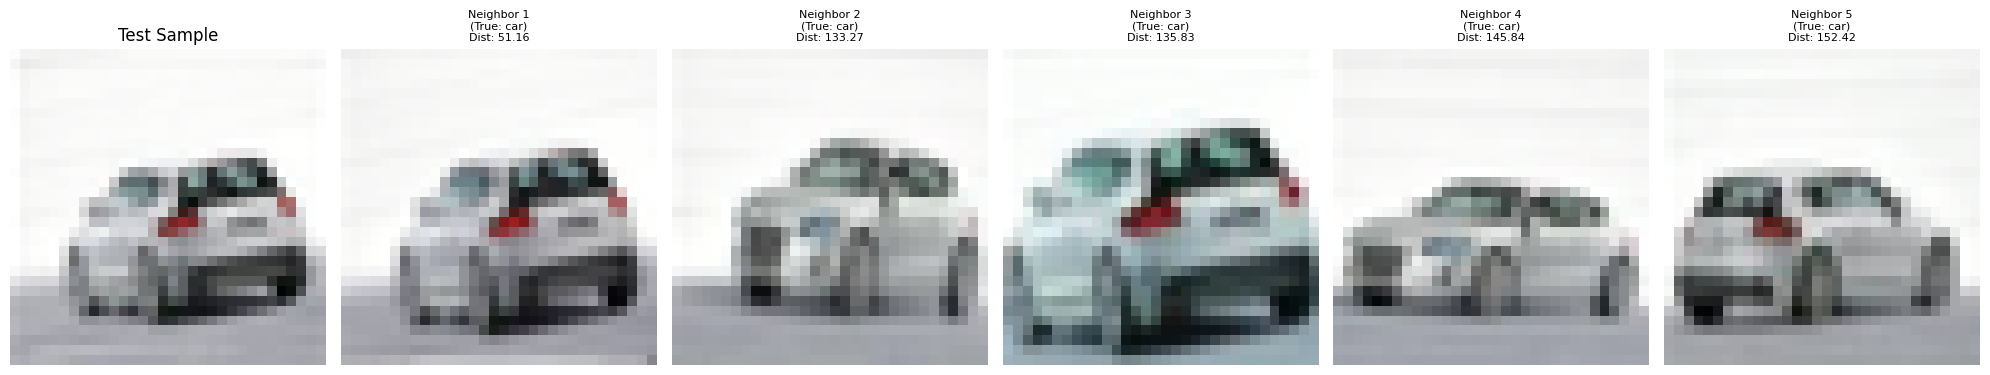

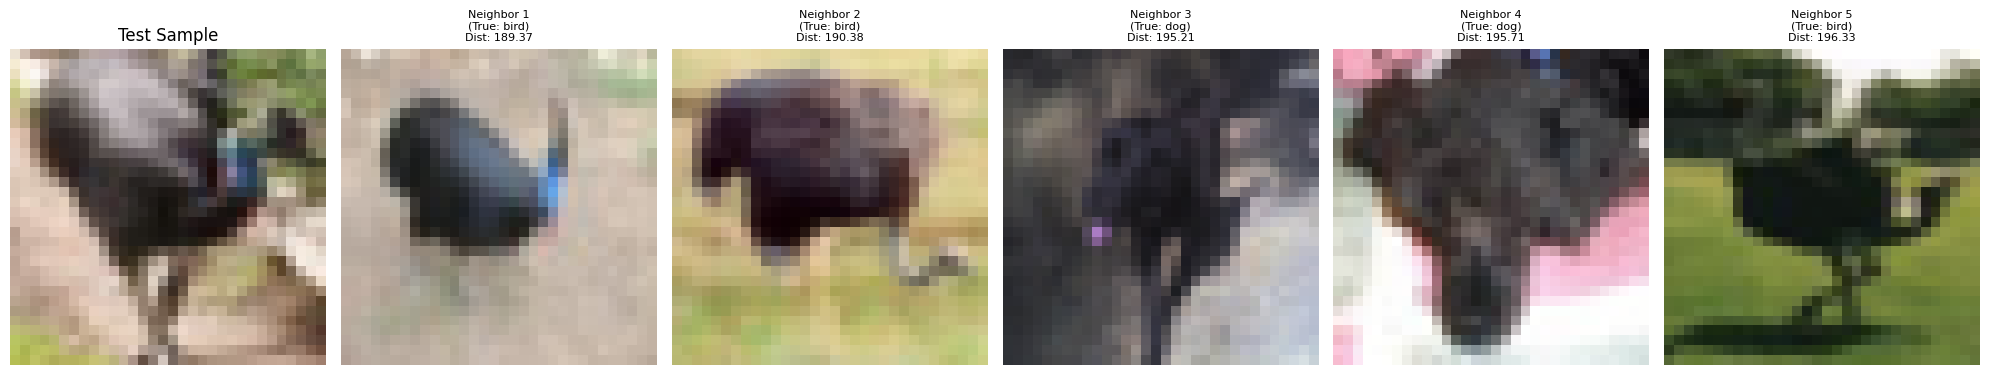

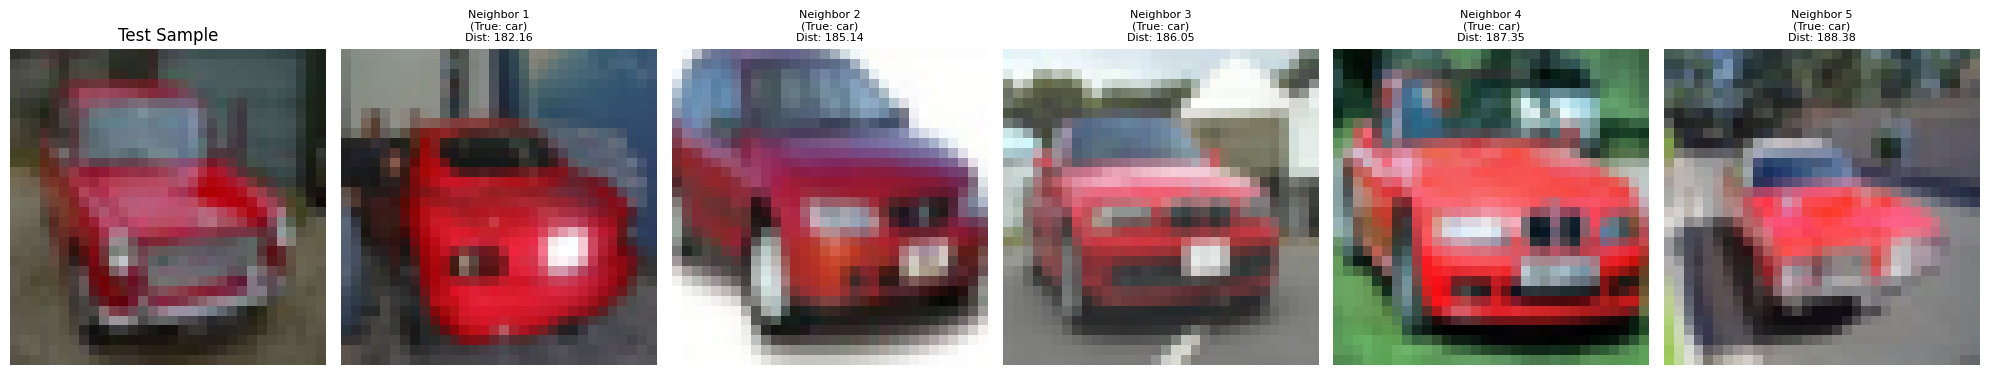

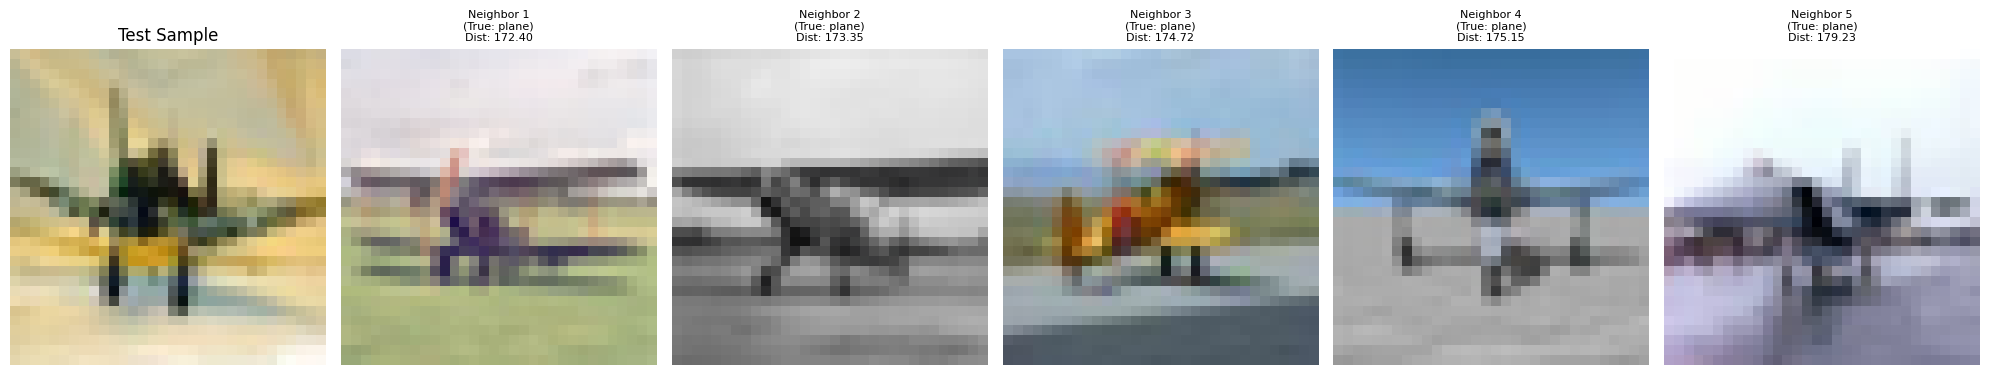

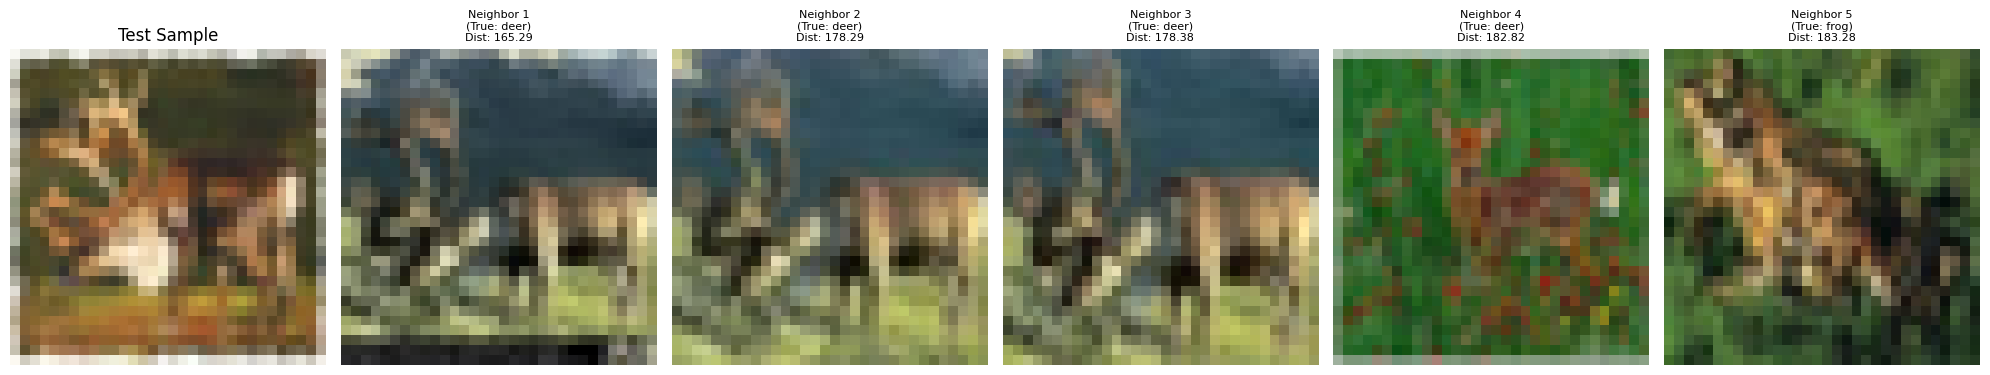

In [30]:
k = 5

model.eval()
correctlly_classified_images = []
device = next(model.parameters()).device

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(testloader):
        images_on_device = images.to(device)
        predicted_labels_batch = model(images_on_device)
        _, predicted_batch = torch.max(predicted_labels_batch.data, 1)

        for i in range(images.size(0)):
            image = images[i]
            label = labels[i]
            predicted = predicted_batch[i]

            if predicted.item() == label.item():
                 correctlly_classified_images.append((image.clone(), predicted.item(), label.item()))

random_correctlly_classified_samples = random.sample(correctlly_classified_images, 5)

knn_results = []

knn_model = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')

knn_model.fit(feature_space.numpy())

for test_image, test_predicted_label, test_true_label in random_correctlly_classified_samples:

    model.eval()
    with torch.no_grad():
        test_image_tensor = test_image.unsqueeze(0).to(device)
        conv_output = model.conv_layers(test_image_tensor)
        flattened_output = conv_output.view(conv_output.size(0), -1)
        test_feature_output = model.feature_space_layer(flattened_output)

    test_feature_vector = test_feature_output.cpu().squeeze(0).numpy()

    distances, k_nearest_indices = knn_model.kneighbors(test_feature_vector.reshape(1, -1))

    distances = distances[0]
    k_nearest_indices = k_nearest_indices[0]

    neighbor_images = []
    neighbor_labels = []
    neighbor_distances = []

    for i, idx in enumerate(k_nearest_indices):
      neighbor_images.append(trainset[idx][0])
      neighbor_labels.append(trainset[idx][1])
      neighbor_distances.append(distances[i])

    knn_results.append({
        'test_image': test_image,
        'true_label': test_true_label,
        'predicted_label': test_predicted_label,
        'neighbor_images': neighbor_images,
        'neighbor_labels': neighbor_labels,
        'neighbor_distances': neighbor_distances
    })
    norminv = UnNormalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261))

    for data in knn_results:
        test_image = data['test_image']
        true_label = data['true_label']
        predicted_label = data['predicted_label']
        neighbor_images = data['neighbor_images']
        neighbor_labels = data['neighbor_labels']
        neighbor_distances = data['neighbor_distances']

    fig, axes = plt.subplots(1, k + 1, figsize=(20, 4))

    unnormalized_test_image = norminv(test_image)
    test_img_array = unnormalized_test_image.permute(1, 2, 0).numpy()
    test_img_array = np.clip(test_img_array, 0, 1)
    axes[0].imshow(test_img_array)
    axes[0].set_title('Test Sample')
    axes[0].axis('off')

    for i in range(k):
        unnormalized_neighbor_image = norminv(neighbor_images[i])
        neighbor_img_array = unnormalized_neighbor_image.permute(1, 2, 0).numpy()
        neighbor_img_array = np.clip(neighbor_img_array, 0, 1)

        ax = axes[i + 1]
        ax.imshow(neighbor_img_array)
        ax.set_title(f'Neighbor {i+1}\n(True: {classes[neighbor_labels[i]]})\nDist: {neighbor_distances[i]:.2f}', fontsize=8)
        ax.axis('off')


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


### TSNE

Let's follow these steps to explore feature space even more:

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now we have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now we have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)


In [31]:
indices = np.random.randint(0, len(feature_space), 2000)
feature_space = feature_space[indices]
tsne = TSNE(n_components=2, random_state=42)
reduced_space = tsne.fit_transform(feature_space.reshape(feature_space.shape[0], -1).detach().cpu().numpy())

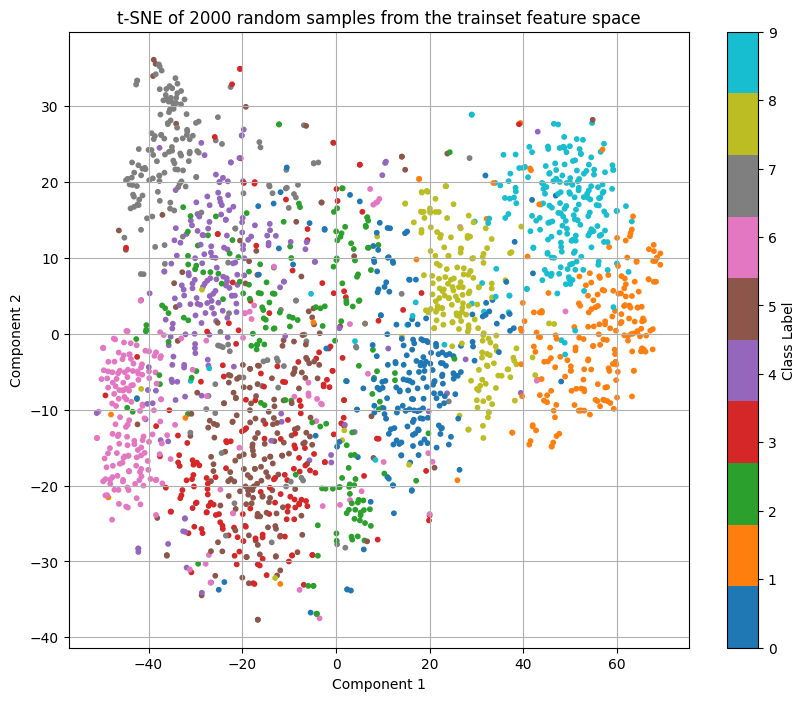

In [32]:
sampled_labels = torch.tensor(trainset.dataset.targets)[trainset.indices][indices]
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_space[:, 0], reduced_space[:, 1], c=sampled_labels, cmap='tab10', s=10)
plt.colorbar(scatter, ticks=range(10), label='Class Label')
plt.title("t-SNE of 2000 random samples from the trainset feature space")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()


### Feature Map


In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's select a random image from dataset.

In [33]:
image = trainset[3][0]

In order to clip the model, use `model.children()` method.




In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
image = image.to(device)

image = image.unsqueeze(0)

clipped = nn.Sequential(
    *list(model.conv_layers.children())[:4]
)

model.eval()
with torch.no_grad():
    intermediate_output = clipped(image)

In [35]:
intermediate_output.shape

torch.Size([1, 64, 32, 32])

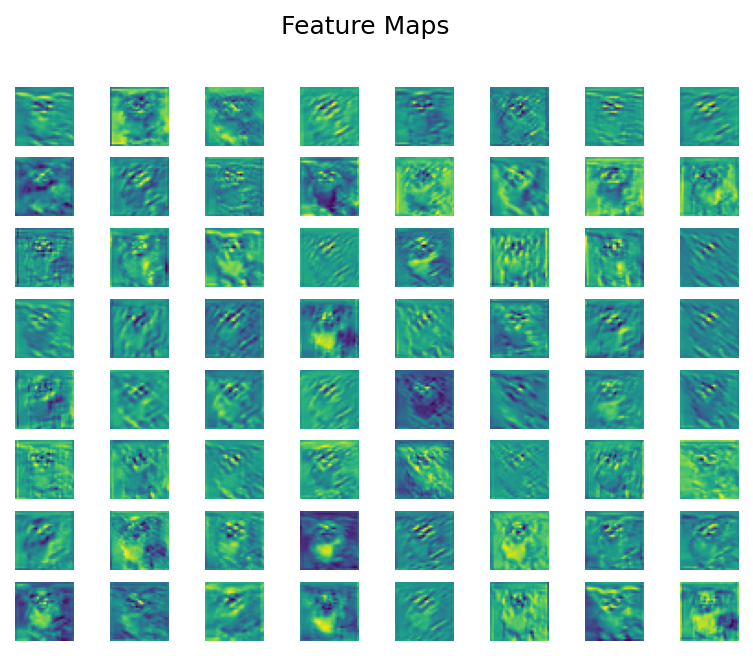

In [36]:
import matplotlib.pyplot as plt

def plot_intermediate_output(result, title=None):
    """
    Plots the intermediate output of shape
    N_FILTERS x H x W
    """
    plt.rcParams['figure.dpi'] = 150
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i*N + j < n_filters:
                axs[i][j].imshow(result[0, i*N + j].cpu().detach())
                axs[i][j].axis('off')

plot_intermediate_output(intermediate_output, title='Feature Maps')